In [59]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import xception
import numpy as np

## Load keras model

In [3]:
model = keras.models.load_model('../models/xception_to_sequential.h5')

2021-12-29 11:42:49.182379: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model

# convert to TFLITE

In [7]:

converter = converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

2021-12-29 11:51:43.129315: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/tmpbtid5oj8/assets


2021-12-29 11:51:44.172880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-29 11:51:44.172901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-29 11:51:44.177237: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/tmpbtid5oj8
2021-12-29 11:51:44.180942: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-29 11:51:44.180966: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/tmpbtid5oj8
2021-12-29 11:51:44.190498: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-29 11:51:44.283275: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/tmpbtid5oj8
2021-12

In [12]:
tflife_model_path = "../models/converted_model_xception_to_sequential.tflite"

In [9]:
open(tflife_model_path, "wb").write(tfmodel)

2166036

In [13]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflife_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [14]:
input_details, output_details

([{'name': 'serving_default_dense_input:0',
   'index': 0,
   'shape': array([   1, 2048], dtype=int32),
   'shape_signature': array([  -1, 2048], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'StatefulPartitionedCall:0',
   'index': 10,
   'shape': array([1, 1], dtype=int32),
   'shape_signature': array([-1,  1], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

# Read in some data

In [19]:
base_folder = '../data/'
data_folder = base_folder + 'fire-dataset/'
train_data_folder = data_folder + 'wildfire'
test_date_folder  = data_folder + 'non-wildfire'

categories = ['wildfire', 'non-wildfire']
len_categories = len(categories)

In [44]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

In [45]:
fire_df = pd.read_csv('../data/fire-dataset/data_df.csv')

In [49]:
test_image = read_img(fire_df['file'][0], (255,255))/255

In [50]:
test_image.min(), test_image.max()

(0.0, 1.0)

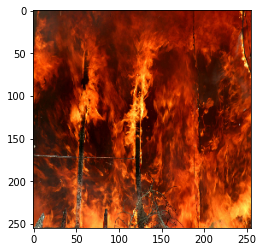

In [51]:
plt.imshow(test_image)

## Get Xception features

In [61]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(np.expand_dims(test_image, 0), batch_size=32, verbose=1)

1/1 [==============================] - 1s 754ms/step


In [62]:
bf_train_x.shape

(1, 2048)

In [63]:
## Set up your input data.
# right = result.rightHand.hand
# input_data = np.array([[res.x, res.y, res.z] for res in right]).flatten()

# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], bf_train_x)
interpreter.invoke()

# Get the result 
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

# e_result = np.argmax(hand)
# prob = str(round(hand[np.argmax(hand)], 2))

[[1.]]


In [ ]:
# It worked! predicted no wildfire